In [1]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from ipsort import *
import time


%matplotlib inline

# Other Approaches and Heuristics
### Other things we can do to speed up the algorithm

We will begin by only sorting rows that are similar to the grouping. I believe this will create a block diagonal structure.

In [2]:
def ipsortMod(A,returnPermu=False,verbose=False):
    """ Group similar rows and columns of a matrix together

        Parameters
        ----------
        A: (mxn ndarray) sparse matrix of zeros and ones to sort
        sortRow: (bool) if sortRow=false, the algorithm sorts columns ONLY
        returnPermu: (bool) if returnPermu=True, the function returns the 
                   permutation vectors and grouping vectors
        verbose: (bool) if verbose=True, the function prints it's progress 
                        through the matrix
        Returns
        -------
        Asorted: (mxn ndarray) permuted A matrix
        perCol (1xn ndarray) column permutations
        perRow = (1xm ndarray) row permutations
        rowGroups = (list) stores the indices that begin each row grouping
        colGroups = (list) stores the indices that begin each row grouping
        
    """
    #Variables to keep track of progress
    M,N = A.shape
    colMark = 0
    rowMark = 0
    
    #For verbose=True
    colProgress = 0
    colStepSize = N//20
    rowProgress = 0
    rowStepSize = M//20
    
    #Variables to store row and column permutations
    perCol = np.arange(N) 
    perRow = np.arange(M) 
    
    #Variables to store the beginnings of each grouping
    rowGroups = [0] 
    colGroups = [0]
    
    A = A.tocsc()
    
    while colMark < N-2:
        #Compute column similarity with a dot product
        scores = A[:,colMark].transpose().dot(A[:,colMark+1:])
        
        #Move the most similar columns to the front
        sort = np.argsort(scores.toarray().ravel())[::-1] 
        permu = list(range(colMark+1)+list(sort+colMark+1))
        A = A[:,permu]
        perCol = perCol[permu]
        
        #Find the end of the grouping
        colFin = np.argmax(np.abs(np.diff(scores.toarray()[:,sort])))
        
        #Compare the rows inside the current column grouping
        scores = A[rowMark,colMark:colMark+colFin+2].dot(
                 A[rowMark+1:,colMark:colMark+colFin+2].transpose() )
        
        #Move similar rows up
        sort = np.argsort(scores.toarray().ravel())[::-1] 
        permu = list(range(rowMark+1)+list(sort+rowMark+1))
        A = A[permu,:]
        perRow = perRow[permu]
        
        #Find the end of the row grouping
        rowFin = np.argmax(np.abs(np.diff(scores.toarray()[:,sort])))
        
        
                
        rowMark += rowFin + 2
        colMark += colFin + 2
        colGroups.append(colMark)
        rowGroups.append(rowMark)
        
        #Print progress
        if verbose:
            if colMark - colProgress > colStepSize:
                steps = colProgress//colStepSize
                print("Column progress: \t{}".format('%'*steps) + '-'*(20-steps-2) +'|')
                colProgress += colStepSize
                
            if rowMark - rowProgress > rowStepSize:
                steps = rowProgress//rowStepSize
                print("Row progress: \t\t{}".format('%'*steps) + '-'*(20-steps-2) +'|')
                rowProgress += rowStepSize
                
    if returnPermu:
        return A,perCol,perRow,colGroups,rowGroups
    return A

We will compare our new sort with the original.

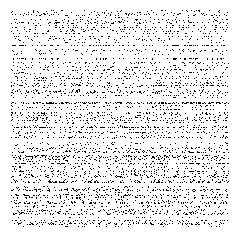

In [3]:
A = shuffSparseArray(N=25,M=25)
plot_coo_matrix(A)
plt.show()

Modified sort in 0.17197394371 sconds


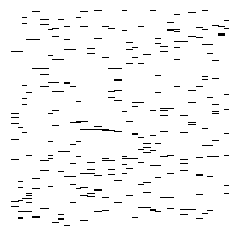

In [4]:
t0 = time.time()
As = ipsortMod(A)
t1 = time.time()
plot_coo_matrix(As)

print("Modified sort in {} sconds".format(t1-t0))
plt.show()

Full sort in 0.401921033859 sconds


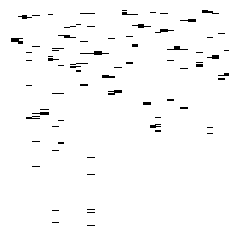

In [5]:
t0 = time.time()
As = ipsort(A)
t1 = time.time()
plot_coo_matrix(As)
print("Full sort in {} sconds".format(t1-t0))
plt.show()

It is much faster, but seems like it doesn't do so well. There may be a problem in the algorithm. We will make a matrix with a hidden block diagonal structure and try it.

In [6]:
def blockShuffSparse(M=100,N=100,noise=False):
    Blocks = []
    

    for i in range(N):
        if noise:
            Blocks.append(np.random.rand(M,N)>.6)
        else:
            Blocks.append(np.ones((M,N)))
    A = sparse.block_diag(Blocks)
        
        
    permuR = np.arange(M**2)
    np.random.shuffle(permuR)
    permuC = np.arange(N**2)
    np.random.shuffle(permuC)
    A = A.tocsc()[:,permuC]
    A = A.tocsr()[permuR,:]

    
        
    return A

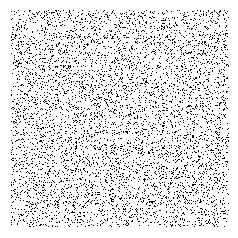

In [7]:
A = blockShuffSparse(M=25,N=25,noise=True)
plot_coo_matrix(A)

Number of Column groups: 29
Number of Row groups: 30


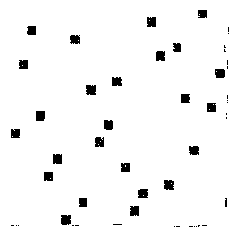

In [8]:
vals = ipsort(A,returnPermu=True)
plot_coo_matrix(vals[0])
print("Number of Column groups: {}".format(len(vals[3])))
print("Number of Row groups: {}".format(len(vals[4])))
plt.show()

A.shape: (625, 625)
Col Groups: 30
Row Groups: 30
Modified sort in 0.136173009872 sconds


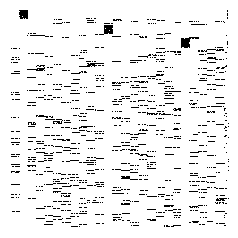

In [9]:
t0 = time.time()
vals = ipsortMod(A,returnPermu=True)
t1 = time.time()
plot_coo_matrix(vals[0])
print("A.shape: {}".format(A.shape))
print('Col Groups: {}'.format(len(vals[3])))
print('Row Groups: {}'.format(len(vals[4])))
print("Modified sort in {} sconds".format(t1-t0))
plt.show()


It seems like even when there is a block diagonal structure, the modified sort fails. This may be because while the rows may match within one column grouping, they may match even better in another grouping.

Number of Column groups: 3422
Number of Row groups: 161


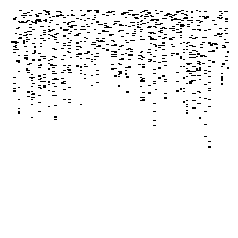

In [10]:
C = shuffSparseArray()
vals = ipsort(C,returnPermu=True)
plot_coo_matrix(vals[0])
print("Number of Column groups: {}".format(len(vals[3])))
print("Number of Row groups: {}".format(len(vals[4])))
plt.show()

In this sorting there is a suprising number of column groups compared to row groups. I'm not happy with the results.

# Other Algorithms

We will begin with a graph theory algorithm aimed at making a matrix more block diagonal.

In [11]:
C = C.tocsr()
permu = sparse.csgraph.reverse_cuthill_mckee(C,symmetric_mode=False)

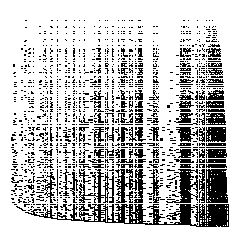

In [12]:
Cnew = C[permu,:]
Cnew = Cnew[:,permu]

plot_coo_matrix(Cnew)
plt.show()

Interesting results. Notice the dense clusters. However, the actual data is not square and this may not work.

We will try generating a matrix that is more like our actual data

In [13]:
def mockProcedureMatrix(M=9000,N=1000):
    #Generates a matrix similar to the medical data
    
    #Generate the distribution of procedures
    Pro1prob = np.random.randint(N,size=N)
    Pro1prob = Pro1prob/float(sum(Pro1prob))
    Pro2prob = np.array([np.random.randint(N,size=N) for i in range(N)])
    Pro2prob = np.apply_along_axis(lambda x: x/float(sum(x)),1,Pro2prob)
    
    allpro = range(N)
    A = sparse.dok_matrix((M,N))
    for i in range(M):
        #For each patient randomly draw a procedure 
        #from the distribution
        
        p1 = np.random.choice(allpro,p=Pro1prob)
        p2 = np.random.choice(allpro,p =Pro2prob[p1])
        p3 = np.random.choice(allpro,p =Pro2prob[p1])
        A[i,p1] = 1
        A[i,p2] = 1
        A[i,p3] = 1
        
    return A.tocsr()

In [14]:
A = mockProcedureMatrix(M=10000,N=10000)

We'll test the two sorting algoithms and compare them on a square matrix

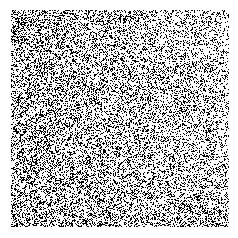

In [15]:
As = ipsort(A,sortRow=True)
plot_coo_matrix(As)
plt.show()

It doesn't look very sorted at all

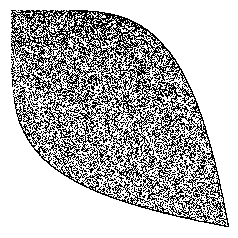

In [16]:
permu = sparse.csgraph.reverse_cuthill_mckee(A)
Anew = A[permu,:]
Anew = Anew[:,permu]
plot_coo_matrix(Anew)

This algorithm doesn't form the data into groups so well either. We will try a machine learning clustering algorithm.

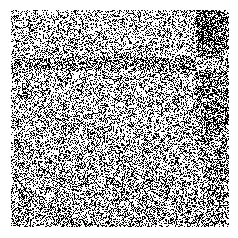

In [17]:
from sklearn.cluster import KMeans
rowGroups = KMeans(n_clusters=1500).fit_predict(A)
colGroups = KMeans(n_clusters=1500).fit_predict(A.transpose())

#K-means sorts the rows into groups. Then we will organize the rows
#and columns of the matrix according to the groups.

rowPermu = np.argsort(rowGroups)
colPermu = np.argsort(colGroups)

Anew = A[rowPermu,:]
Anew = Anew[:,colPermu]
plot_coo_matrix(Anew)
plt.show()

There appears to be a pattern, but it isn't a very useful one yet. We'll rewrite the plotting function to plot the different groups together.

In [18]:
def plot_kmean_matrix(m,sparsePlot=False):
    """ Plots nonzero entries of sparse array m as black pixels
        Credit to:
        https://stackoverflow.com/questions/22961541/
        python-matplotlib-plot-sparse-matrix-pattern
    """

    if not isinstance(m, sparse.coo_matrix):
        m = sparse.coo_matrix(m)
    
    y_pre = KMeans(n_clusters=10).fit_predict(m)
    colors = np.array([y_pre[r] for r in m.row])
    
    if sparsePlot:
        col = m.col[colors!=0] 
        row = m.row[colors!=0] 
        colors = colors[colors!=0]
    else:
        col = m.col
        row = m.row
        
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='white')
     
    ax.scatter(col,row, c=colors, marker=",",s=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

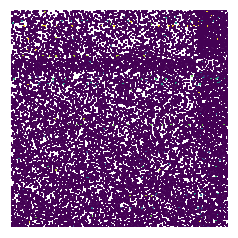

In [19]:
plot_kmean_matrix(Anew)
plt.show()

It looks like most of the data is in the first group. We'll plot the data outside the first group

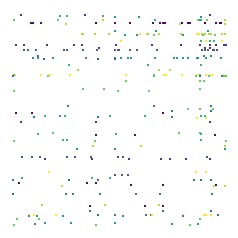

In [20]:
plot_kmean_matrix(Anew,sparsePlot=True)
plt.show()

We will try clustering algorithms on 

Tall spoof data. First 1000 rows


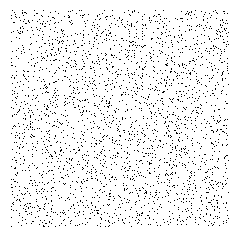

In [22]:
Tall = mockProcedureMatrix()
print('Tall spoof data. First 1000 rows')
plot_coo_matrix(Tall[:1000,:])
plt.show()

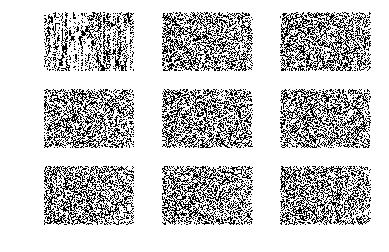

In [133]:
TallSort = ipsort(Tall).tocoo()

def plotTallMatrix(A):
    """ Plots first nine blocks of the given matrix in squares"""
    A = A.tocoo()
    m,n = A.shape
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        mask = (A.row > i*n) * (A.row < (i+1)*n)
        cols = A.col[mask]
        rows = A.row[mask]
        plt.plot(cols, rows, marker=',', color='black', lw=0,linestyle="")
        plt.axis('off')
    plt.show()
    
plotTallMatrix(TallSort)

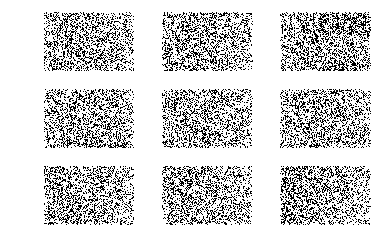

In [49]:
rowGroups = KMeans(n_clusters=1000).fit_predict(Tall)
colGroups = KMeans(n_clusters=1000).fit_predict(Tall.transpose())

#K-means sorts the rows into groups. Then we will organize the rows
#and columns of the matrix according to the groups.

rowPermu = np.argsort(rowGroups)
colPermu = np.argsort(colGroups)

Tallnew = Tall[rowPermu,:]
Tallnew = Tallnew[:,colPermu]
plotTallMatrix(Tallnew)

We can see slightly better clustering here, but still not great

Since the data is not clustering in a meaningful way, we will try to change the row and column group cutoff for ipsort and try it again

In [61]:
def halfIpsort(A, returnPermu=False,verbose=False, dataMatches=-1):
    """ Group similar rows and columns of a matrix together

        Parameters
        ----------
        A: (mxn ndarray) sparse matrix of zeros and ones to sort
        sortRow: (bool) if sortRow=false, the algorithm sorts columns ONLY
        returnPermu: (bool) if returnPermu=True, the function returns the 
                   permutation vectors and grouping vectors
        verbose: (bool) if verbose=True, the function prints it's progress 
                        through the matrix
        dataMatches: (int) The minimum number of places data must match to 
                           be included in a cluster. If -1 a natural stopping point
                           is used instead.
        Returns
        -------
        Asorted: (mxn ndarray) permuted A matrix
        perRow = (1xm ndarray) row permutations
        perCol (1xn ndarray) column permutations
        rowGroups = (list) stores the indices that begin each row grouping
        colGroups = (list) stores the indices that begin each row grouping
    """
    #Variables to keep track of progress
    M,N = A.shape
    mark = 0
    progress = 0
    printStepSize = N//20
    
    #Variables to store row and column permutations
    perCol = np.arange(N) 
    perRow = np.arange(M) 
    
    #Variables to store the beginnings of each grouping
    rowGroups = [0] 
    colGroups = [0]
    
    A = A.tocsc()
    while mark < N-2:
        #Compute column similarity with a dot product
        scores = A[:,mark].transpose().dot(A[:,mark+1:])
        
        #Move the most similar columns to the front
        sort = np.argsort(scores.toarray().ravel())[::-1] 
        permu = list(range(mark+1)+list(sort+mark+1))
        A = A[:,permu]
        perCol = perCol[permu]
        
        #Find the end of the grouping
        if dataMatches >= 0:
            sortedScores =  list(scores.toarray()[:,sort])
            try:
                fin = sortedScores.index(dataMatches) + 1
            except ValueError:
                fin = 1
        else:
            fin = np.argmax(np.abs(np.diff(scores.toarray()[:,sort]))) + 2
            
        mark += fin
        colGroups.append(mark)
        
        if verbose:
            if mark - progress > printStepSize:
                steps = progress//printStepSize
                print("Column progress: \t{}".format('%'*steps) + '-'*(20-steps-2) +'|')
                progress += printStepSize
            

    if returnPermu:
        return A,perRow,perCol,rowGroups,colGroups
    return A

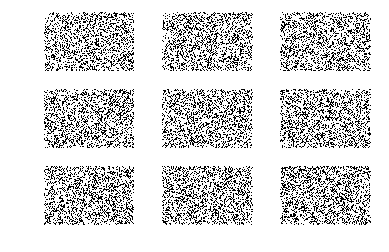

In [65]:
TallHSort = halfIpsort(Tall.transpose(),dataMatches = 4).transpose()
plot_tall_matrix(TallHSort)

In [135]:
def anotherSort(A):
    m,n = A.shape
    rowgroups = [0]
    for i in range(n):
        mask = (A[rowgroups[-1]:,i] == 1).toarray().ravel()
        finished = list(range(rowgroups[-1]))
        unfinished = np.arange(rowgroups[-1],m)
        permu = finished+list(unfinished[mask]) + list(unfinished[~mask])
        rowgroups.append(sum(mask)+rowgroups[-1])
        
        if rowgroups[-1] > m:
            break
        else:
            A = A[permu,:]
    return A,rowgroups
    

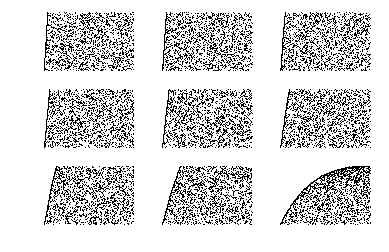

In [136]:
TallASort = anotherSort(Tall)[0]
plot_tall_matrix(TallASort)
plt.show()